In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


Found 4 images belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Predicted likelihood: 0.9978
Actual label: 1


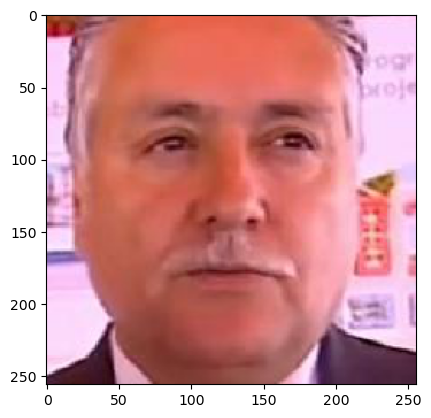

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_dimensions = {"height": 256, "width": 256, "channels": 3}

class Classifier:
    def __init__(self):
        self.model = None

    def predict(self, x):
        if x.size == 0:
            return []
        return self.model.predict(x)

    def fit(self, x, y):
        return self.model.train_on_batch(x, y)

    def get_accuracy(self, x, y):
        return self.model.test_on_batch(x, y)

    def load(self, path):
        self.model.load_weights(path)

class Meso4(Classifier):
    def __init__(self, learning_rate=0.001):
        super().__init__()
        self.model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def init_model(self):
        x = Input(shape=(image_dimensions["height"], image_dimensions["width"], image_dimensions["channels"]))
        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)
        return Model(inputs=x, outputs=y)

# Instantiate the model
meso = Meso4()
meso.model.load_weights("Meso4_DF.h5")

# Example usage with a generator
data_generator = ImageDataGenerator(rescale=1./255)
generator = data_generator.flow_from_directory(
    'test_images',
    target_size=(256, 256),
    batch_size=1,
    class_mode='binary'
)

X, y = next(generator)
print(f"Predicted likelihood: {meso.predict(X)[0][0]:.4f}")
print(f"Actual label: {int(y[0])}")

# Visualize the input image
plt.imshow(np.squeeze(X))
plt.show()


In [5]:
pip install Flask

Note: you may need to restart the kernel to use updated packages.


In [8]:
from flask import Flask, request, render_template
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import os

app = Flask(__name__)

class Meso4:
    def __init__(self, learning_rate=0.001):
        self.model = self.init_model()
        optimizer = Adam(learning_rate=learning_rate)
        self.model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def init_model(self):
        x = Input(shape=(256, 256, 3))  # Adjust shape based on `image_dimensions`
        x1 = Conv2D(8, (3, 3), padding='same', activation='relu')(x)
        x1 = BatchNormalization()(x1)
        x1 = MaxPooling2D(pool_size=(2, 2), padding='same')(x1)
        x2 = Conv2D(8, (5, 5), padding='same', activation='relu')(x1)
        x2 = BatchNormalization()(x2)
        x2 = MaxPooling2D(pool_size=(2, 2), padding='same')(x2)
        x3 = Conv2D(16, (5, 5), padding='same', activation='relu')(x2)
        x3 = BatchNormalization()(x3)
        x3 = MaxPooling2D(pool_size=(2, 2), padding='same')(x3)
        x4 = Conv2D(16, (5, 5), padding='same', activation='relu')(x3)
        x4 = BatchNormalization()(x4)
        x4 = MaxPooling2D(pool_size=(4, 4), padding='same')(x4)
        y = Flatten()(x4)
        y = Dropout(0.5)(y)
        y = Dense(16)(y)
        y = LeakyReLU(alpha=0.1)(y)
        y = Dropout(0.5)(y)
        y = Dense(1, activation='sigmoid')(y)
        model = Model(inputs=x, outputs=y)
        return model

meso = Meso4()
meso.model.load_weights("Meso4_DF.h5")

def model_predict(img_path, model):
    img = load_img(img_path, target_size=(256, 256))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0  # rescale as during training
    preds = model.predict(img)
    return preds[0][0]

@app.route('/', methods=['GET'])
def index():
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def upload():
    if 'file' not in request.files:
        return "No file part"
    
    f = request.files['file']
    
    if f.filename == '':
        return "No selected file"
    
    # Ensure the uploads directory exists
    if not os.path.exists('./uploads'):
        os.makedirs('./uploads')

    # Save the file to ./uploads
    file_path = os.path.join('./uploads', f.filename)
    f.save(file_path)
    
    # Make prediction
    prediction = model_predict(file_path, meso.model)
    result = f'Predicted likelihood: {prediction:.4f}'
    
    return result

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with watchdog (windowsapi)


SystemExit: 1

C:\Users\Dell\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


<html lang="en">
<head>
<meta charset="UTF-8">
<title>Image Classification</title>
</head>
<body>
<h1>Upload an image</h1>
<form action="/predict" method="post" enctype="multipart/form-data">
    <input type="file" id ="f1" name="f1" accept="/png" />
    <input type="submit" value="Upload and Predict" />
</form>
</body>
</html>
